In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import time
import torch.nn.functional as F
import pickle
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
class Transformer(tf.keras.Model):

    def __init__(self, src_vocab_size, tgt_vocab_size, hidden_size, window_size, nhead, **kwargs):
        super().__init__(**kwargs)
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.encoder = TransformerBlock(
            self.hidden_size,
            nhead=nhead,
            type='encoder'
        )
        self.decoder = TransformerBlock(
            self.hidden_size,
            nhead=nhead,
            type='decoder'
        )

        self.src_encoding = PositionalEncoding(
            self.src_vocab_size,
            self.hidden_size,
            self.window_size
        )
        
        self.tgt_encoding = PositionalEncoding(
            self.tgt_vocab_size,
            self.hidden_size,
            self.window_size
        )
        
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(units=int(2 * self.tgt_vocab_size), activation='relu'),
            tf.keras.layers.Dense(units=self.tgt_vocab_size)
        ])

    def call(self, src_inputs, tgt_inputs, src_padding_mask=None, tgt_padding_mask=None):
        probs = None
        src_embeddings = self.src_encoding(src_inputs)
        tgt_embeddings = self.tgt_encoding(tgt_inputs)
        encoder_output = self.encoder(src_embeddings, src_padding_mask)
        decoder_output = self.decoder(tgt_embeddings, encoder_output)
        probs = self.classifier(decoder_output)
        return probs

    def encode(self, src_inputs):
        src_embedding = self.src_encoding(src_inputs)
        return self.encoder.encode(src_embedding)

    def decode(self, tgt_inputs, encoder_output):
        tgt_embedding = self.tgt_encoding(tgt_inputs)
        output = self.decoder.decode(tgt_embedding, encoder_output)
        return self.classifier(output)

    def get_embedding(self, words):
        return self.tgt_encoding.embedding(words)

class AttentionMatrix(tf.keras.layers.Layer):

    def __init__(self, *args, use_mask=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_mask = use_mask

    def call(self, inputs):
        K, Q = inputs
        window_size_queries = Q.get_shape()[1]
        window_size_keys = K.get_shape()[1]
        mask_vals = np.triu(np.ones((window_size_queries, window_size_keys)) * np.NINF, k=1)
        mask = tf.convert_to_tensor(value=mask_vals, dtype=tf.float32)
        atten_mask = tf.tile(tf.reshape(mask, [-1, window_size_queries, window_size_keys]),
                             [tf.shape(input=K)[0], 1, 1])
        attention_logits = tf.matmul(Q, K, transpose_b=True)
        
        dk = tf.cast(tf.shape(K)[1], tf.float32)
        attention_logits = attention_logits / tf.math.sqrt(dk)
        if self.use_mask == True:
            attention_logits = tf.add(attention_logits, atten_mask)
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        return attention_weights


class AttentionHead(tf.keras.layers.Layer):
    def __init__(self, input_size, output_size, is_self_attention, **kwargs):
        super(AttentionHead, self).__init__(**kwargs)
        self.use_mask = is_self_attention
        self.K = tf.Variable(tf.random.normal(shape=[input_size, output_size], stddev=0.01, dtype=tf.float32),
                             trainable=True)
        self.V = tf.Variable(tf.random.normal(shape=[input_size, output_size], stddev=0.01, dtype=tf.float32),
                             trainable=True)
        self.Q = tf.Variable(tf.random.normal(shape=[input_size, output_size], stddev=0.01, dtype=tf.float32),
                             trainable=True)
        self.attention_matrix = AttentionMatrix(use_mask=self.use_mask)

    @tf.function
    def call(self, inputs_for_keys, inputs_for_values, inputs_for_queries):
        K = tf.tensordot(inputs_for_keys, self.K, axes=1)
        V = tf.tensordot(inputs_for_values, self.V, axes=1)
        Q = tf.tensordot(inputs_for_queries, self.Q, axes=1)

        attention_matrix = self.attention_matrix([K, Q])
        attention = tf.matmul(attention_matrix, V)
        return attention


class MultiHeadedAttention(tf.keras.layers.Layer):
    def __init__(self, emb_sz, use_mask, nhead, **kwargs):
        super(MultiHeadedAttention, self).__init__(**kwargs)

        self.heads = [AttentionHead(input_size=emb_sz, output_size=emb_sz // nhead, is_self_attention=use_mask)
                      for _ in range(nhead)]
        self.emb_sz = emb_sz
        self.dense = tf.keras.layers.Dense(units=emb_sz)

    @tf.function
    def call(self, inputs_for_keys, inputs_for_values, inputs_for_queries):
        attns = [head(inputs_for_keys, inputs_for_values, inputs_for_queries) for head in self.heads]
        att = tf.concat(tuple(attns), axis=2)
        att = self.dense(att)
        return att


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, emb_sz, nhead=3, type='decoder', **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.type = type
        self.ff_layer = tf.keras.layers.Dense(units=emb_sz)
        self.self_atten = MultiHeadedAttention(emb_sz, True, nhead=nhead)
        if self.type == 'decoder':
            self.cross_atten = MultiHeadedAttention(emb_sz, False, nhead=nhead)
        self.layer_norm = tf.keras.layers.LayerNormalization()


    @tf.function
    def call(self, inputs, context_sequence):
        if self.type == 'decoder':
            return self.decode(inputs, context_sequence)
        elif self.type == 'encoder':
            return self.encode(inputs)
        else:
            raise Exception("Invalid transformer block type")

    def encode(self, inputs):
        attn = self.self_atten(inputs, inputs, inputs)
        attn = self.layer_norm(inputs + attn)
        ff = self.ff_layer(attn)
        ff = self.layer_norm(attn + ff)
        return ff

    def decode(self, inputs, context_sequence):
        encoder_self_attention = self.self_atten(inputs, inputs, inputs)
        masked_encoder_self_attention = self.layer_norm(encoder_self_attention + inputs)

        if len(context_sequence.shape) != 3:
            context_sequence = tf.expand_dims(context_sequence, axis=1)
        unmasked_attention = self.cross_atten(context_sequence, context_sequence, masked_encoder_self_attention)
        unmasked_attention = self.layer_norm(unmasked_attention + masked_encoder_self_attention)

        ff = self.ff_layer(unmasked_attention)
        ff = self.layer_norm(ff + unmasked_attention)
        return tf.nn.relu(ff)

def positional_encoding(length, depth):
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_size, window_size):
        super().__init__()
        self.embed_size = embed_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero=True)
        self.pos_encoding = positional_encoding(length=window_size, depth=embed_size)

    def call(self, x):
        embdding = self.embedding(x)
        embdding *= tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
        pos_code = self.pos_encoding
        return embdding + pos_code[:embdding.shape[1], :]

In [ ]:
def truncate(arr, size):
    if len(arr) > size:
        return arr[:size + 1]
    else:
        copy = arr.copy()
        copy += (size + 1 - len(arr)) * ['<pad>']
        return copy

In [ ]:
statistics = []

In [ ]:
import numpy as np
import tensorflow as tf


class DishIngredientPredictorModel(tf.keras.Model):

    def __init__(self, predictor, src_w2i, src_i2w, tgt_w2i, tgt_i2w, **kwargs):
        super().__init__(**kwargs)
        self.predictor = predictor
        self.src_w2i = src_w2i
        self.src_i2w = src_i2w
        self.tgt_w2i = tgt_w2i
        self.tgt_i2w = tgt_i2w


    @tf.function
    def call(self, dish_names, ingredient_names, src_padding_mask=None, tgt_padding_mask=None):
        return self.predictor(dish_names, ingredient_names, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)

    def predict(self, dish_names):
        if type(self.predictor) == Transformer:
            dish_names = truncate(dish_names, self.predictor.window_size - 1)
            
        w2i = lambda dish: self.src_w2i[dish] if dish in self.src_w2i else self.src_w2i['<unk>']
        tokens = [w2i(word) for word in dish_names]
        src_token = tf.convert_to_tensor(tokens)
        src_token = tf.expand_dims(src_token, axis=0)

        tgt_token = self.predict_token(src_token)
        lst = []
        for sentence in tgt_token:
            for each in sentence:
                lst.append(self.tgt_i2w[tf.get_static_value(each)])

        return ', '.join([ingredient for ingredient in lst[1:] if ingredient not in ['<end>', '<pad>', '<start>', '<unk>']])

    def predict_token(self, src_tokens):
        num_tokens = src_tokens.shape[0]
        tgt_token = self.greedy_decode(src_tokens, max_len=20)
        return tgt_token

    def encode(self, src_tokens):
        return self.predictor.encode(src_tokens)

    def decode(self, tgt_inputs, encoder_state):
        return self.predictor.decode(tgt_inputs, encoder_state)

    def greedy_decode(self, src_tokens, max_len, start_symbol='<start>', end_symbol='<end>'):
        if type(self.predictor) == Transformer:
            hidden_state = self.encode(src_tokens)
        else:
            hidden_output, hidden_state = self.encode(src_tokens)
        seen_ids = set()
        sentence = [self.tgt_w2i[start_symbol]]
        ys = tf.convert_to_tensor([sentence])
        for i in range(max_len):
            out = self.decode(ys, hidden_state)
            next_word = tf.math.argmax(out[:, -1], axis=1, output_type=tf.int32)
            ys = tf.concat([ys, tf.expand_dims(next_word, axis=1)], axis=1)
            if self.tgt_i2w[tf.get_static_value(next_word[0])] == end_symbol:
                break
        return ys

    def compile(self, optimizer, loss, metrics):
        self.optimizer = optimizer
        self.loss_function = loss
        self.accuracy_function = metrics[0]
        self.similarity_function = metrics[1]
        self.jaccard_similarity = metrics[2]
    
    def train(self, train_ingredients, train_dishes, src_padding_index, tgt_padding_index, batch_size=100):

        avg_loss = 0
        avg_acc = 0
        avg_prp = 0

        num_batches = max(1, int(len(train_ingredients) / batch_size))

        total_loss = total_seen = total_correct = 0
        for index, end in enumerate(range(batch_size, len(train_ingredients)+1, batch_size)):
            start = end - batch_size
            batch_dishes = train_dishes[start:end, :-1]
            decoder_input = train_ingredients[start:end, :-1]
            decoder_labels = train_ingredients[start:end, 1:]
            src_padding_mask = tf.cast(tf.math.equal(batch_dishes, src_padding_index), tf.float32)
            tgt_padding_mask = tf.cast(tf.math.equal(decoder_input, tgt_padding_index), tf.float32)
            with tf.GradientTape() as tape:
                predictions = self.call(batch_dishes, decoder_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
                mask = decoder_labels != tgt_padding_index
                loss = self.loss_function(predictions, decoder_labels, mask)

            gradients = tape.gradient(loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

            num_predictions = tf.reduce_sum(tf.cast(mask, tf.float32))
            accuracy = self.accuracy_function(predictions, decoder_labels, mask)
            
            jaccard_similarity = self.jaccard_similarity(predictions, decoder_labels)

            total_loss += loss
            total_seen += num_predictions
            total_correct += accuracy

            avg_loss = total_loss / total_seen
            avg_acc = total_correct / total_seen
            avg_prp = np.exp(avg_loss)
            print(f'\rTrain {index+1}/{num_batches} - loss: {avg_loss:.4f} - jaccard_similarity: {jaccard_similarity:.4f} - perplexity: {avg_prp:.4f}', end='')
        print()
        statistics.append([avg_loss.numpy(),jaccard_similarity,avg_prp])
        return avg_loss, avg_acc, avg_prp


    def test(self, train_ingredients, train_dishes, src_padding_index, tgt_padding_index, batch_size=100):

        avg_loss = 0
        avg_acc = 0
        avg_prp = 0

        num_batches = max(1, int(len(train_ingredients) / batch_size))

        total_loss = total_seen = total_correct = 0
        for index, end in enumerate(range(batch_size, len(train_ingredients)+1, batch_size)):
            start = end - batch_size
            batch_dishes = train_dishes[start:end, :-1]
            decoder_input = train_ingredients[start:end, :-1]
            decoder_labels = train_ingredients[start:end, 1:]
            src_padding_mask = tf.cast(tf.math.equal(batch_dishes, src_padding_index), tf.float32)
            tgt_padding_mask = tf.cast(tf.math.equal(decoder_input, tgt_padding_index), tf.float32)

            predictions = self.call(batch_dishes, decoder_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
            mask = decoder_labels != tgt_padding_index
            loss = self.loss_function(predictions, decoder_labels, mask)

            num_predictions = tf.reduce_sum(tf.cast(mask, tf.float32))
            accuracy = self.accuracy_function(predictions, decoder_labels, mask)
            
            jaccard_similarity = self.jaccard_similarity(predictions, decoder_labels)

            total_loss += loss
            total_seen += num_predictions
            total_correct += accuracy

            avg_loss = total_loss / total_seen
            avg_acc = total_correct / total_seen
            avg_prp = np.exp(avg_loss)
            print(f'\rTest {index+1}/{num_batches} - loss: {avg_loss:.4f} - jaccard_similarity: {jaccard_similarity:.4f} - perplexity: {avg_prp:.4f}', end='')
        print()
        return avg_loss, avg_acc, avg_prp


def accuracy_function(prbs, labels, mask):
    correct_classes = tf.math.argmax(prbs, axis=-1, output_type=tf.int32) == labels
    accuracy = tf.reduce_mean(tf.boolean_mask(tf.cast(correct_classes, tf.float32), mask))
    return accuracy


def jaccard_similarity(prbs, labels):
    words_pred = tf.math.argmax(prbs, axis=-1, output_type=tf.int32)

    redundant = {'<unk>', '<start>', '<end>'}

    similarity = 0.0
    for s1, s2 in zip(words_pred, labels):
        words_unique = set(s1.numpy().tolist())
        label_unique = set(s2.numpy().tolist())
        words_unique = words_unique - redundant
        label_unique = label_unique - redundant

        similarity += len(words_unique & label_unique) / len(words_unique | label_unique)
    return similarity / len(words_pred)


def similarity_function(prbs, labels, model):
    words_pred = tf.math.argmax(prbs, axis=-1, output_type=tf.int32)

    words_pred_emb = model.predictor.get_embedding(words_pred)
    labels_emb = model.predictor.get_embedding(labels)

    words_pred_emb = tf.sort(words_pred_emb, axis=-1)
    labels_emb = tf.sort(labels_emb, axis=-1)

    sim = tf.keras.losses.CosineSimilarity()
    sz = tf.shape(words_pred_emb)[0] * tf.shape(words_pred_emb)[1] * tf.shape(words_pred_emb)[2]
    w = tf.reshape(words_pred_emb, sz)
    l = tf.reshape(labels_emb, sz)
    similarity = sim(w, l)
    return similarity


def loss_function(prbs, labels, mask):

    masked_labs = tf.boolean_mask(labels, mask)
    masked_prbs = tf.boolean_mask(prbs, mask)
    scce = tf.keras.losses.sparse_categorical_crossentropy(masked_labs, masked_prbs, from_logits=True)
    loss = tf.reduce_sum(scce)
    return loss

In [ ]:
def parse_args(args=None):
    parser = argparse.ArgumentParser(description="Let's train some neural nets!", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--type',           required=True,              choices=['rnn', 'transformer'],     help='Type of model to train')
    parser.add_argument('--task',           required=False,              choices=['train', 'test', 'both'],  help='Task to run')
    parser.add_argument('--data',           required=False,              help='File path to the assignment data file.')
    parser.add_argument('--epochs',         type=int,   default=3,      help='Number of epochs used in training.')
    parser.add_argument('--lr',             type=float, default=1e-3,   help='Model\'s learning rate')
    parser.add_argument('--optimizer',      type=str,   default='adam', choices=['adam', 'rmsprop', 'sgd'], help='Model\'s optimizer')
    parser.add_argument('--nhead',          type=int,   default=3,      help='Number of heads in the transformer model')
    parser.add_argument('--batch_size',     type=int,   default=100,    help='Model\'s batch size.')
    parser.add_argument('--hidden_size',    type=int,   default=256,    help='Hidden size used to instantiate the model.')
    parser.add_argument('--window_size',    type=int,   default=20,     help='Window size of text entries.')
    parser.add_argument('--chkpt_path',     default='',                 help='where the model checkpoint is')
    parser.add_argument('--check_valid',    default=False,               action="store_true",  help='if training, also print validation after each epoch')
    parser.add_argument('--debug',          default=False,               action="store_true",  help='skip training')
    if args is None:
        return parser.parse_args()
    return parser.parse_args(args)

In [ ]:
import re
import pickle

import argparse
import numpy as np
import pickle
import tensorflow as tf

def compile_model(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=loss_function,
                  metrics=[accuracy_function, similarity_function, jaccard_similarity])


def train_model(model, src_inputs, tgt_inputs, src_pad_idx, tgt_pad_idx, args, valid):
    stats = []
    n = args.epochs
    try:
        for epoch in range(args.epochs):
            print('Epoch '+ str(epoch + 1))
            stats += [model.train(tgt_inputs, src_inputs, src_pad_idx, tgt_pad_idx, batch_size=args.batch_size)]
            if args.check_valid:
                model.test(valid[0], valid[1], src_pad_idx, tgt_pad_idx, batch_size=args.batch_size)
    except KeyboardInterrupt as e:
        if epoch > 0:
            print("Key-value interruption. Trying to early-terminate. Interrupt again to not do that!")
        else:
            raise e
    return stats


def build_model(args):
    with open('dataPreprocessed.p', 'rb') as f:
        data = pickle.load(f)

    train_size = -45000
    src_train_inputs = data['X'][:-train_size]
    tgt_train_inputs = data['Y'][:-train_size]
    src_test_inputs = data['X'][-5000:]
    tgt_test_inputs = data['Y'][-5000:]
    src_w2i = data['dish_word2idx']
    tgt_w2i = data['ingredient_word2idx']
    src_i2w = data['dish_idx2word']
    tgt_i2w = data['ingredient_idx2word']
    src_vocab_size = data['dish_vocab_size']
    tgt_vocab_size = data['ingredient_vocab_size']

    print('src_vocab_size', src_vocab_size)
    print('tgt_vocab_size', tgt_vocab_size)

    dt = tf.int32
    src_train_inputs = tf.convert_to_tensor(src_train_inputs, dtype=dt)
    tgt_train_inputs = tf.convert_to_tensor(tgt_train_inputs, dtype=dt)
    src_test_inputs = tf.convert_to_tensor(src_test_inputs, dtype=dt)
    tgt_test_inputs = tf.convert_to_tensor(tgt_test_inputs, dtype=dt)

    print('src_train_inputs shape: ', src_train_inputs.shape)
    print('tgt_train_inputs shape: ', tgt_train_inputs.shape)
    print('src_test_inputs dtype: ', src_test_inputs.shape)
    print('tgt_test_inputs dtype: ', tgt_test_inputs.shape)

    hidden_size = args.hidden_size
    window_size = args.window_size

    predictor = Transformer(src_vocab_size, tgt_vocab_size, hidden_size, window_size, nhead = 3)

    model = DishIngredientPredictorModel(
        predictor,
        src_w2i,
        src_i2w,
        tgt_w2i,
        tgt_i2w
    )

    compile_model(model)

    if True:
        train_model(model, src_train_inputs, tgt_train_inputs, src_w2i['<pad>'], tgt_w2i['<pad>'], args, (src_test_inputs, tgt_test_inputs))

    if 'X_test' in data:
        X_test = data['X_test']
        Y_test = data['Y_test']

        try:
            for dish, ingredients in zip(X_test, Y_test):
                print('dish', dish)
                print('ingredients', ingredients)
                prediction = model.predict(dish)
                print('predicted ingredients', prediction)
                inter = set(ingredients).intersection(set(prediction))
                union = set(ingredients).union(set(prediction))
                print('Jaccard Similarity:', len(inter) / len(union))
                print()
        except:
            print('Error happens in batch test.')

    return model, (src_test_inputs, tgt_test_inputs)

In [ ]:
model = build_model(parse_args('--type transformer --nhead 2 --epochs 15 --batch_size 100 --hidden_size 256'.split()))
model = model[0]

In [ ]:
with open('/statistics/stats3','wb') as s:
   pickle.dump(statistics, s)

In [ ]:
with open('/statistics/stats','rb') as s:
    nh3hs256 = pickle.load(s)
with open('/statistics/stats1','rb') as s:
    nh3hs128 = pickle.load(s)
with open('/statistics/stats3','rb') as s:
    nh2hs256 = pickle.load(s)

In [ ]:
import matplotlib.pyplot as plt

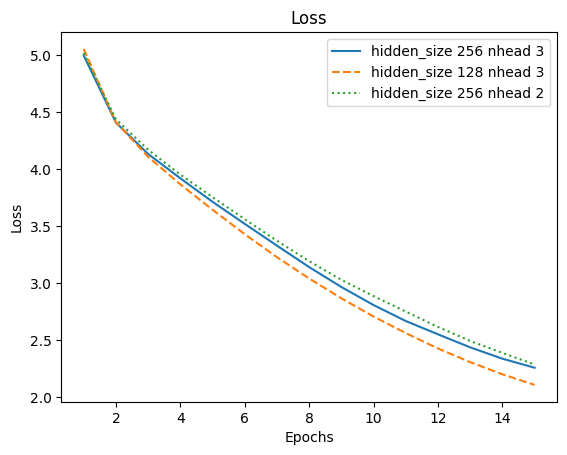

In [ ]:
plt.plot(range(1,16),[i[0] for i in nh3hs256],linestyle='solid')
plt.plot(range(1,16),[i[0] for i in nh3hs128],linestyle='dashed')
plt.plot(range(1,16),[i[0] for i in nh2hs256],linestyle='dotted')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["hidden_size 256 nhead 3", "hidden_size 128 nhead 3", "hidden_size 256 nhead 2"], loc ="upper right")

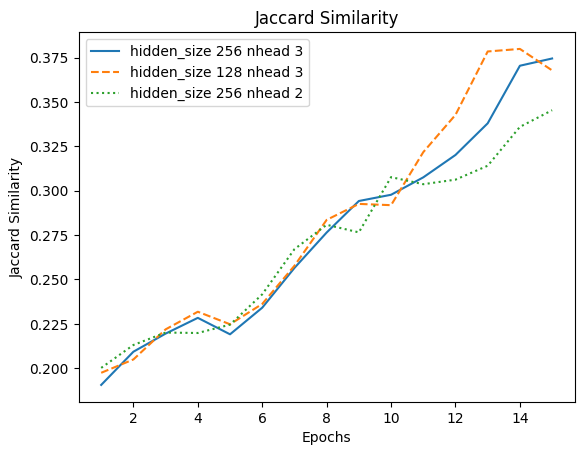

In [ ]:
plt.plot(range(1,16),[i[1] for i in nh3hs256],linestyle='solid')
plt.plot(range(1,16),[i[1] for i in nh3hs128],linestyle='dashed')
plt.plot(range(1,16),[i[1] for i in nh2hs256],linestyle='dotted')
plt.title("Jaccard Similarity")
plt.xlabel("Epochs")
plt.ylabel("Jaccard Similarity")
plt.legend(["hidden_size 256 nhead 3", "hidden_size 128 nhead 3", "hidden_size 256 nhead 2"], loc ="upper left")

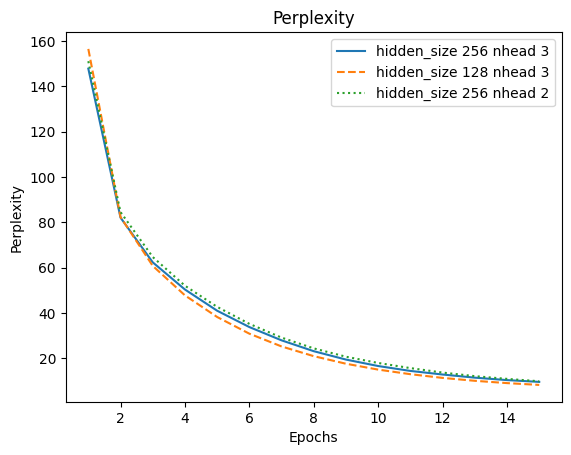

In [ ]:
plt.plot(range(1,16),[i[2] for i in nh3hs256],linestyle='solid')
plt.plot(range(1,16),[i[2] for i in nh3hs128],linestyle='dashed')
plt.plot(range(1,16),[i[2] for i in nh2hs256],linestyle='dotted')
plt.title("Perplexity")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.legend(["hidden_size 256 nhead 3", "hidden_size 128 nhead 3", "hidden_size 256 nhead 2"], loc ="upper right")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_transforms = transforms.Compose([ transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])])

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torch.autograd import Variable

classModel = EfficientNet.from_pretrained('efficientnet-b2')
num_ftrs = classModel._fc.in_features
classModel._fc = nn.Linear(num_ftrs, 308)
classModel = classModel.to(device)

saved_state = torch.load('efnet.pth')
classModel.load_state_dict(saved_state)
classModel.eval()

with open("classList", "rb") as fp:
    x = pickle.load(fp)

Loaded pretrained weights for efficientnet-b2


In [ ]:
def predict_image(image):
    img = Image.open(image)
    image_tensor = test_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = classModel(input)
    value = output.data.cpu().numpy()
    index = value.argmax()
    fig = plt.figure(figsize=(3,3))
    plt.title(x[index])
    plt.axis('off')
    plt.imshow(img,interpolation='nearest')
    fig.tight_layout(pad=1.0)
    plt.show()
    return x[index]

In [ ]:
model = build_model(parse_args('--type transformer --nhead 3 --epochs 20 --batch_size 100 --hidden_size 256'.split()))
model = model[0]

src_vocab_size 1744
tgt_vocab_size 2702
src_train_inputs shape:  (50000, 21)
tgt_train_inputs shape:  (50000, 21)
src_test_inputs dtype:  (1000, 21)
tgt_test_inputs dtype:  (1000, 21)
Epoch 1
Train 500/500 - loss: 4.9997 - jaccard_similarity: 0.1984 - perplexity: 148.3684
Epoch 2
Train 500/500 - loss: 4.4197 - jaccard_similarity: 0.2128 - perplexity: 83.0701
Epoch 3
Train 500/500 - loss: 4.1440 - jaccard_similarity: 0.2191 - perplexity: 63.0574
Epoch 4
Train 500/500 - loss: 3.9259 - jaccard_similarity: 0.2233 - perplexity: 50.7005
Epoch 5
Train 500/500 - loss: 3.7171 - jaccard_similarity: 0.2241 - perplexity: 41.1462
Epoch 6
Train 500/500 - loss: 3.5131 - jaccard_similarity: 0.2465 - perplexity: 33.5505
Epoch 7
Train 500/500 - loss: 3.3126 - jaccard_similarity: 0.2542 - perplexity: 27.4558
Epoch 8
Train 500/500 - loss: 3.1216 - jaccard_similarity: 0.2666 - perplexity: 22.6817
Epoch 9
Train 500/500 - loss: 2.9633 - jaccard_similarity: 0.2757 - perplexity: 19.3624
Epoch 10
Train 500/500 

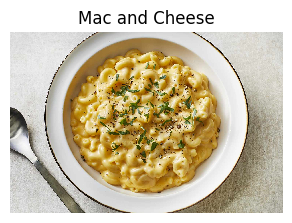

Ingredients of Mac and Cheese:
macaroni
warm water
salt
light cream
feta cheese
milk
butter



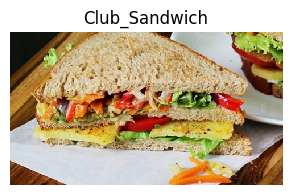

Ingredients of Club_Sandwich:
white bread
butter
swiss cheese
ham
romaine lettuce
tomato
roast red pepper
red onion
brie cheese
caraway seed
egg
milk



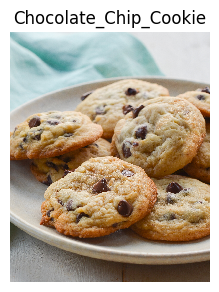

Ingredients of Chocolate_Chip_Cookie:
unsalte butter
light brown sugar
granulate sugar
pure vanilla extract
all purpose flour
bake soda
salt
bittersweet chocolate
unsalte butter
pure vanilla extract
semisweet mini chocolate chip



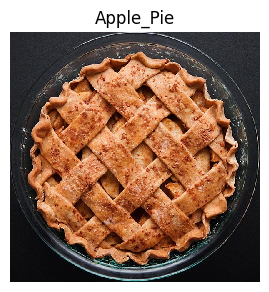

Ingredients of Apple_Pie:
all purpose flour
apple
salt
unsalte butter
granny smith apple
lemon juice
sugar
ground cinnamon
nutmeg
walnut



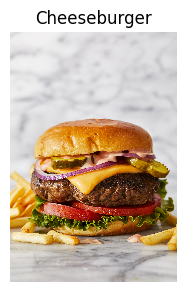

Ingredients of Cheeseburger:
lean ground beef
onion
garlic
green pepper
celery
tomato
salt
pepper
tomato sauce
lettuce



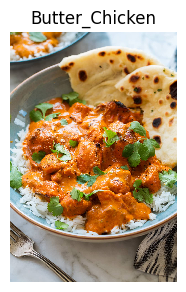

Ingredients of Butter_Chicken:
boneless chicken
garlic clove
fresh ginger
ground cardamom
chili paste
salt, boneless chicken
coriander



In [ ]:
folder = "sampleimages"
for image in os.listdir(folder):
    img_path = os.path.join(folder,image)
    if os.path.isfile(img_path):
        name = predict_image(img_path)
        print("Ingredients of "+str(name)+":")
        name = name.lower().split('_')
        ing = model.predict(name)
        ing = ing.split(', ')
        for ingr in ing:
            print(ingr)
        print()